In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output

import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.utils.np_utils import to_categorical  

Using TensorFlow backend.


## Constants

In [2]:
img_size = 112

train_data_dir = 'data/train_dataset/'  
dev_data_dir = 'data/dev_dataset/'  

epochs = 50
batch_size = 8

num_class = 120

## Data

In [3]:
def generator(datagen, data_dir, class_mode):
    return datagen.flow_from_directory(
        data_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=False,
        seed=0,
    )

datagen = ImageDataGenerator(rescale=1./255)

train_generator = generator(datagen, train_data_dir, 'categorical')
dev_generator = generator(datagen, dev_data_dir, 'categorical')

Found 9144 images belonging to 120 classes.
Found 1078 images belonging to 120 classes.


In [5]:
train_labels = to_categorical(train_generator.classes)
dev_labels = to_categorical(dev_generator.classes)

In [6]:
np.save('./data/bottleneck_features/train_labels.npy', train_labels)
np.save('./data/bottleneck_features/dev_labels.npy', dev_labels)

## Base Model

In [7]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

In [8]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         
__________

In [9]:
bottleneck_features_train = base_model.predict_generator(train_generator, len(train_generator), verbose=1)
np.save('./data/bottleneck_features/bottleneck_features_train.npy', bottleneck_features_train)

1143/1143 [==============================] - 1260s 1s/step


In [10]:
bottleneck_features_dev = base_model.predict_generator(dev_generator, len(dev_generator), verbose=1)
np.save('./data/bottleneck_features/bottleneck_features_dev.npy', bottleneck_features_dev)

135/135 [==============================] - 153s 1s/step


## Callbacks

In [3]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
        self.ax1 = ax1
        self.ax2 = ax2
    
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        self.ax1.plot(self.x, self.losses, label="loss")
        self.ax1.plot(self.x, self.val_losses, label="val loss")
        self.ax1.legend()
        self.ax2.plot(self.x, self.acc, label="accuracy")
        self.ax2.plot(self.x, self.val_acc, label="val accuracy")
        self.ax2.legend()
        plt.show()
        
        print(logs)
        for i in range(self.i):
            print('Epoch ' + str(i+1))
            print('-----------------------')
            print('- Loss:', self.losses[i])
            print('- Accuracy:', self.acc[i])
            print('- Validation loss:', self.val_losses[i])
            print('- Validation accuracy:', self.val_acc[i])
            print(' ')

## Top Model

In [4]:
train_data = np.load('./data/bottleneck_features/bottleneck_features_train.npy')
dev_data = np.load('./data/bottleneck_features/bottleneck_features_dev.npy')
train_labels = np.load('./data/bottleneck_features/train_labels.npy')
dev_labels = np.load('./data/bottleneck_features/dev_labels.npy')

In [5]:
inputs = Input(shape=(train_data.shape[1], train_data.shape[2], train_data.shape[3]))
X = Flatten()(inputs)
X = Dense(2048, activation='relu')(X)
X = Dropout(0.5)(X)
X = Dense(1024, activation='relu')(X)

outputs = Dense(num_class, activation='softmax')(X)

top_model = Model(inputs=inputs, outputs=outputs)

top_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

plot_losses = PlotLosses()

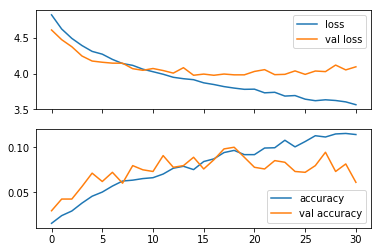

{'val_loss': 4.0954837914079372, 'val_categorical_accuracy': 0.061224489795918366, 'loss': 3.5638144822466926, 'categorical_accuracy': 0.11428258967629046}
Epoch 1
-----------------------
- Loss: 4.824115205
- Accuracy: 0.0157480314961
- Validation loss: 4.6120127048
- Validation accuracy: 0.0296846011132
 
Epoch 2
-----------------------
- Loss: 4.62551488735
- Accuracy: 0.0242782152231
- Validation loss: 4.47581419741
- Validation accuracy: 0.0426716141002
 
Epoch 3
-----------------------
- Loss: 4.49389505908
- Accuracy: 0.0294181977253
- Validation loss: 4.37674208607
- Validation accuracy: 0.0426716141002
 
Epoch 4
-----------------------
- Loss: 4.39357318882
- Accuracy: 0.038167104112
- Validation loss: 4.24680775924
- Validation accuracy: 0.056586270872
 
Epoch 5
-----------------------
- Loss: 4.31168683203
- Accuracy: 0.0458223972003
- Validation loss: 4.17632883688
- Validation accuracy: 0.0714285714286
 
Epoch 6
-----------------------
- Loss: 4.27281374568
- Accuracy: 0.0

KeyboardInterrupt: 

In [6]:
top_model.fit(train_data, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[plot_losses], 
          validation_data=(dev_data, dev_labels))